# Model Creation - 2

### This model will look at local changes in rating, using vintage data to justify these changes

Model 2 takes in training dataset 2. This data is filtered to take all the producers and winetypes from the top districts within the most popular region and countries. The dataset adds a single set of weather data for each district, so many data points with have the same weather data. This approach will look to see the effect less of weather and more on the influence of other metrics such as price and vintage taste quantifiers. This data takes in the same districts as machine learning model 1, however just expands the amount of wine data used. 

Of important note, the purpose of the 3 machine learning models changed throughout the project. The final purpose of the models is more exploratory, with no predicting actually being done on the data. As such, hyperparamter tuning will be ignored, as the model will not be used within the scope of this project to predict anything. Instead, more focus was given to feature selection and iterating through these to find relevant features. The reason for this is to show the relationship between features and rating, proving that there is a relationship. 

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import interp1d
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style = "whitegrid", palette="muted", context="talk")

# Set Matplotlib rcParams
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.titlesize': 20,
    'axes.labelsize': 15,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5
})

## Import Data
Start by importing the training and testing data.

In [2]:
train = pd.read_csv(r'C:\Users\fwhal\Downloads\CME528\Project\Repo-2\BreakinBadCode\Final_DataFrames\FINAL_training_data_Model2_FINAL.csv')
train

,Producer,WineType,District,Year,Ratings_Average,Price,Acidity,Intensity,Sweetness,Tannin,...,December Cumulative Rain (mm),December Cumulative Snow (mm),December Cumulative Precip (mm),December Avg Cloud Cover (%),December Max Wind Speed (Km/h),December Min Wind Speed (Km/h),December Avg Wind Speed (Km/h),December Avg Daylight Hours,December Days Below 0 (°C),December Days Above 32 (°C)
0,trinite estate,acaibo,Sonoma,2018,4.1,100.80,4.0,5.0,1.0,4.5,...,75.900000,0.00,75.900000,60.690860,25.346148,0.36,6.735369,9.532272,0.0,0.0
1,trinite estate,acaibo,Sonoma,2016,4.1,100.80,4.0,5.0,1.0,4.5,...,118.899999,0.00,118.899999,54.302419,19.645580,0.00,6.646974,9.530239,0.0,0.0
2,trinite estate,acaibo,Sonoma,2015,4.1,100.80,4.0,5.0,1.0,4.5,...,145.100001,0.00,145.100001,62.354838,26.302181,0.36,7.692760,9.533807,0.0,0.0
3,trinite estate,acaibo,Sonoma,2014,4.2,100.80,4.0,5.0,1.0,4.5,...,280.000000,0.00,280.000000,73.610215,34.093730,0.36,7.827738,9.532552,0.0,0.0
4,trinite estate,acaibo,Sonoma,2013,4.1,100.80,4.0,5.0,1.0,4.5,...,8.500000,0.07,8.570000,26.384409,18.218275,0.36,5.389955,9.531514,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45986,quinta vale d. maria,vinhas do sabor superior tinto,Freixo de Espada a Cinta,2006,4.3,103.14,3.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45987,quinta vale d. maria,vinhas do sabor superior tinto,Freixo de Espada a Cinta,2005,4.0,103.14,3.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45988,quinta vale d. maria,vinhas do sabor superior tinto,Freixo de Espada a Cinta,2004,4.0,103.14,3.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45989,quinta vale d. maria,vinhas do sabor superior tinto,Freixo de Espada a Cinta,2003,4.2,103.14,3.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Anlysis
Visially and graphically look at data

Looking at the districts below, we can see clear time dependent trends in the data 
- Data looks almost random. Will use weather data to explain trends

In [3]:
train['District'].unique()

array(['Sonoma', 'Tulare', 'San Luis Obispo', 'Napa', 'Mendocino',
       'Nechako', 'Thompson--Okanagan', 'San Rafael', 'Luján de Cuyo',
       'Tunuyán', 'San Carlos', 'Tupungato', 'Barossa', 'Onkaparinga',
       'Unincorporated SA', 'Wattle Range', 'Toscana', 'Umbria', 'Marche',
       'Lazio', 'Gironde', 'Provincia de Elqui', 'Dordogne', 'Creuse',
       'Deux-Sèvres', 'Charente', 'Rioja, La',
       'Clare and Gilbert Valleys', 'Vancouver Island and Coast / *',
       'Torre de Moncorvo', 'Freixo de Espada a Cinta'], dtype=object)

No visible trend initially across the years for rating average
- No change in older vintages with ratings
- Too much data

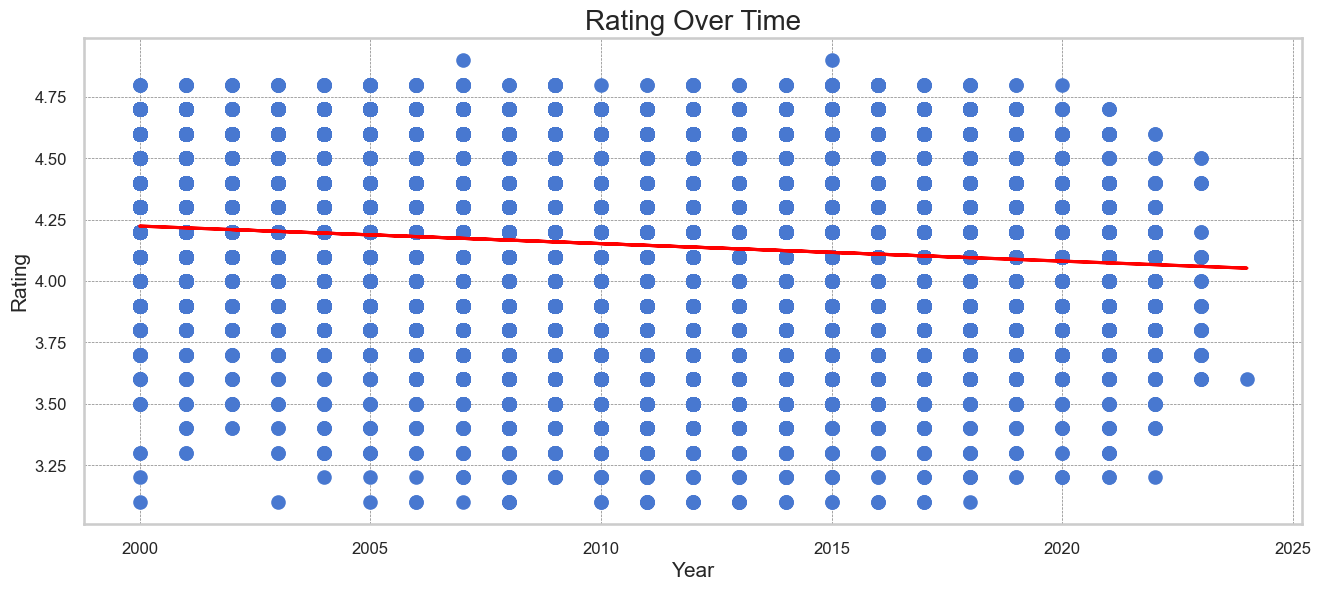

In [4]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Set out lineplot and data
plt.scatter(x = train['Year'], y = train['Ratings_Average'])
m, b = np.polyfit(train['Year'], train['Ratings_Average'], 1)
plt.plot(train['Year'], m*train['Year'] + b, color='red', label='Line of Best Fit')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

Looking at a heatmap, we can see a slight increasing trend of ratings with years

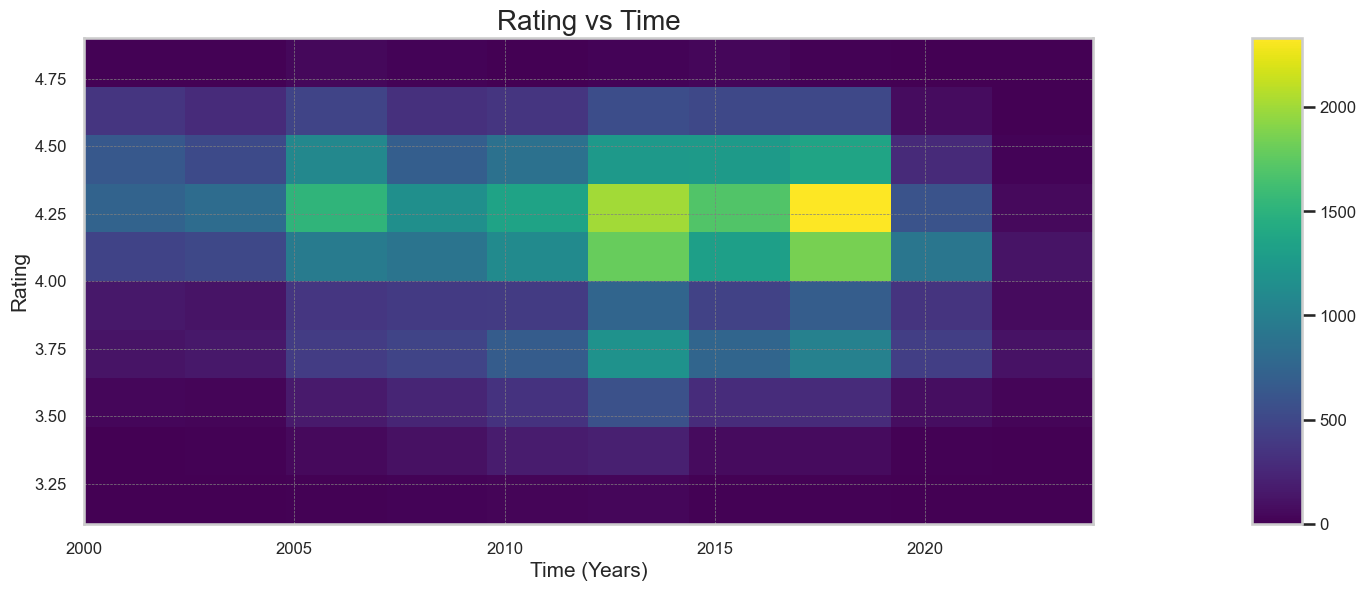

In [5]:
#Define figure size
fig = plt.figure(figsize = (14, 6)) 
gs = fig.add_gridspec(1, 2, width_ratios = [20, 1], wspace=0.3)

#Create heatmap
heatmap, xedges, yedges = np.histogram2d(train['Year'], train['Ratings_Average'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#Add Heatmap
ax0 = fig.add_subplot(gs[0, 0])
img = ax0.imshow(heatmap.T, extent = extent, origin = 'lower', cmap = 'viridis', aspect = 'auto')
ax0.set_title('Rating vs Time')
ax0.set_xlabel('Time (Years)')
ax0.set_ylabel('Rating')

#Add colour bar
ax1 = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(img, cax=ax1)

#Plot
plt.show()


Looking at a few districts, can see a small dependency of time with rating
- Initially looking at years as a clear distinction can be seen

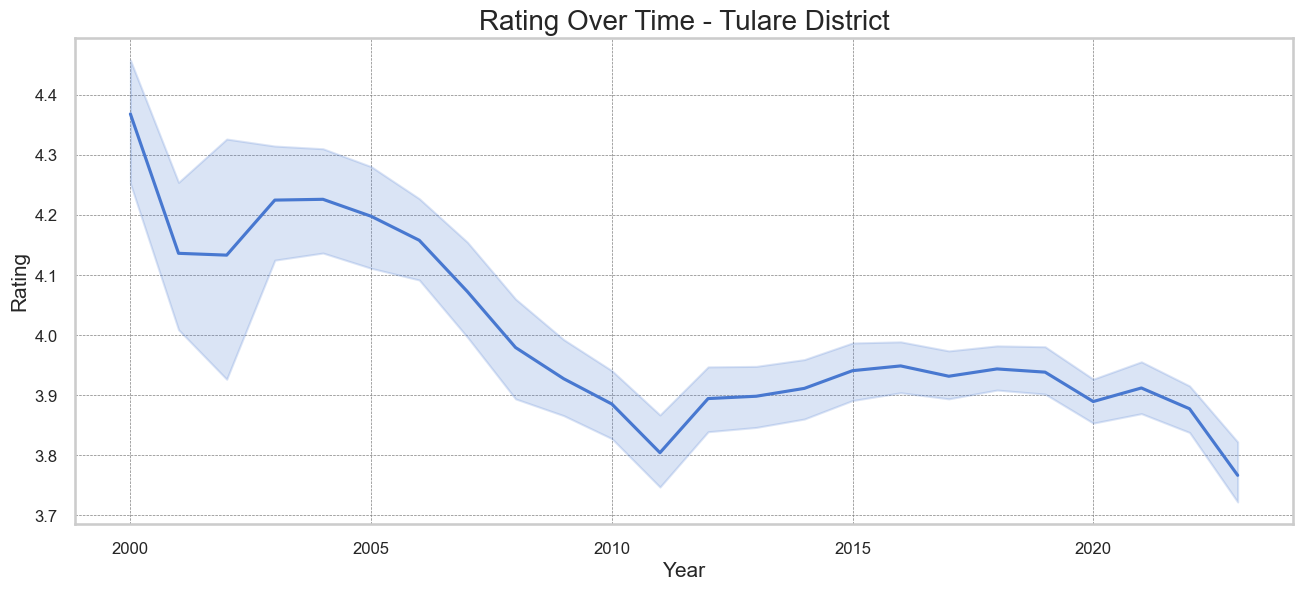

In [6]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Set out lineplot and data
sns.lineplot(data = train[train['District'] == 'Tulare'], x = 'Year', y = 'Ratings_Average')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time - Tulare District', fontsize = 20)

#Show the plot
plt.show()

Can see a decreaing trend across the years for this district
- Some bottles will show a time dependent aspect, as older vintages typically will have better ratings

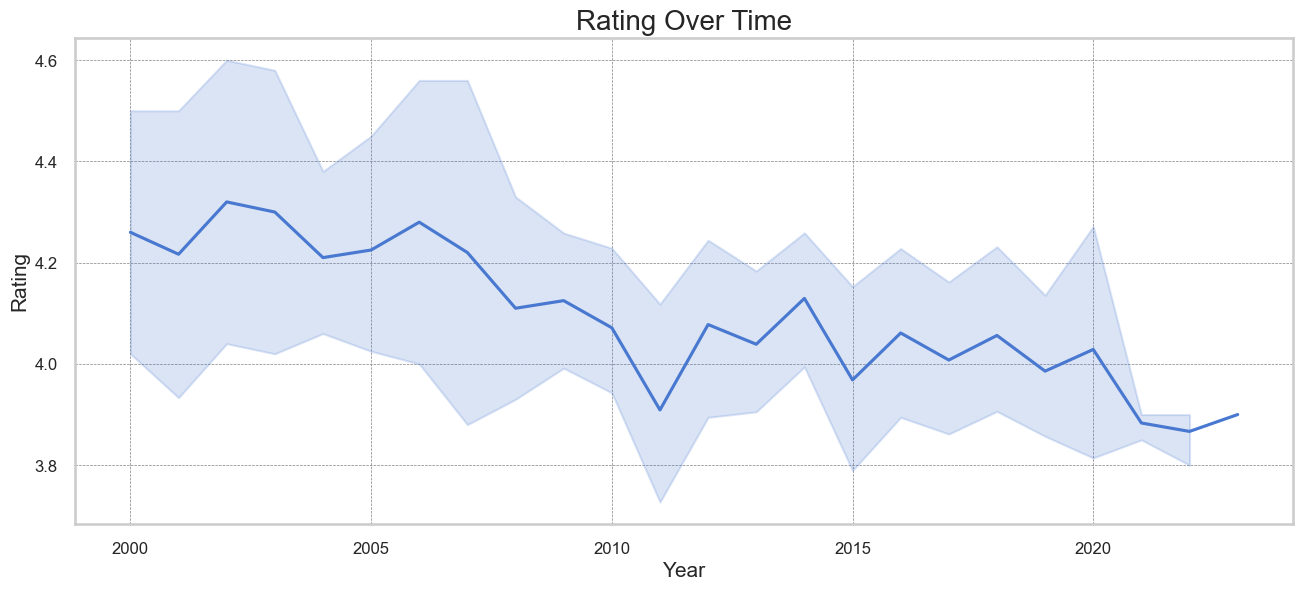

In [7]:
#Set out figure size
plt.figure(figsize=(14, 6))
sns.lineplot(data = train[train['District'] == 'Wattle Range'], x = 'Year', y = 'Ratings_Average')

#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

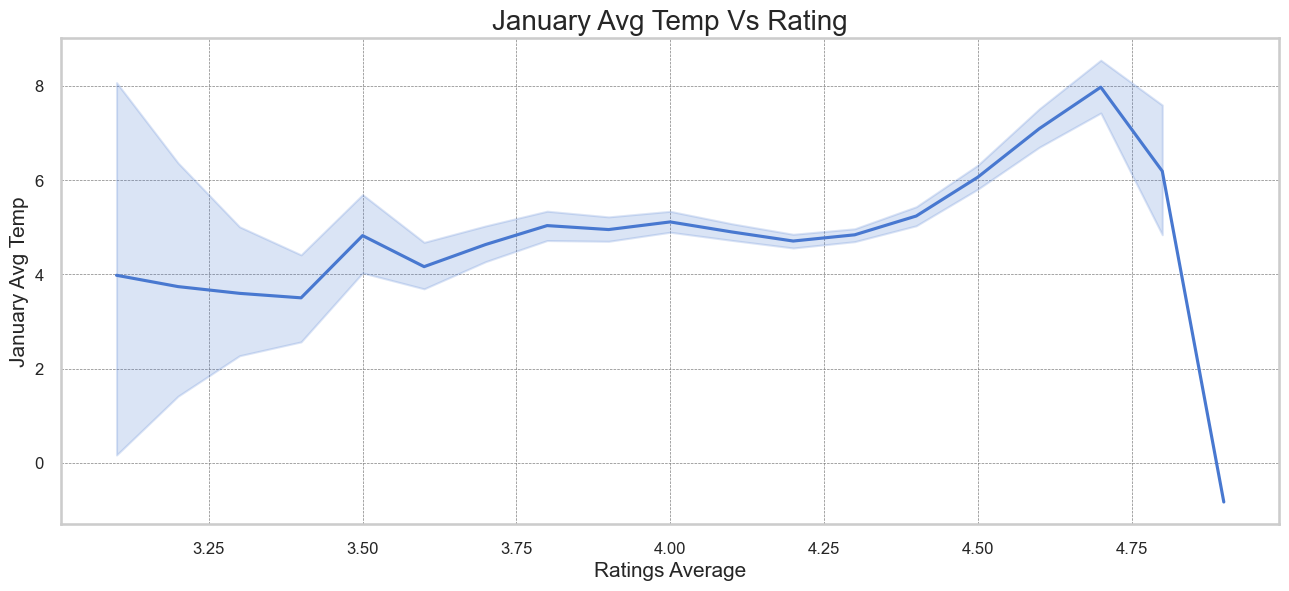

In [8]:
#Set out figure size
plt.figure(figsize=(14, 6))
sns.lineplot(data = train , x = 'Ratings_Average', y = 'January Avg Temp (°C)')

#Adding labels and title
plt.xlabel('Ratings Average')
plt.ylabel('January Avg Temp')
plt.title('January Avg Temp Vs Rating')

#Show the plot
plt.show()

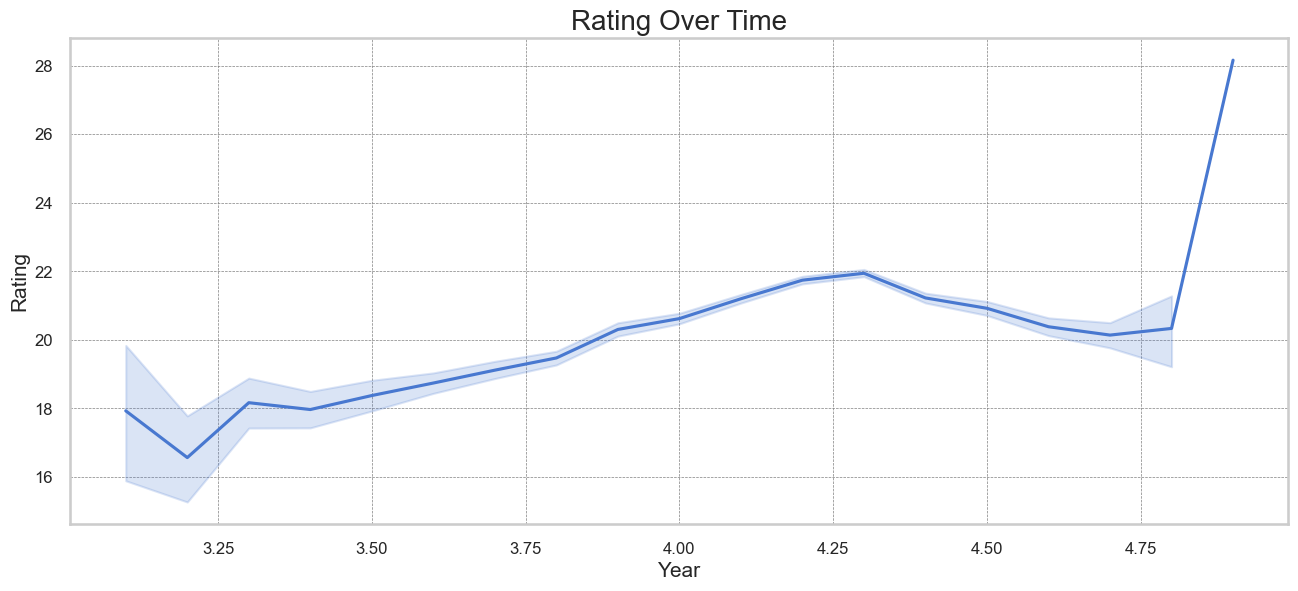

In [9]:
#Set out figure size
plt.figure(figsize=(14, 6))
sns.lineplot(data = train , x = 'Ratings_Average', y = 'August Avg Temp (°C)')



#Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating Over Time')

#Show the plot
plt.show()

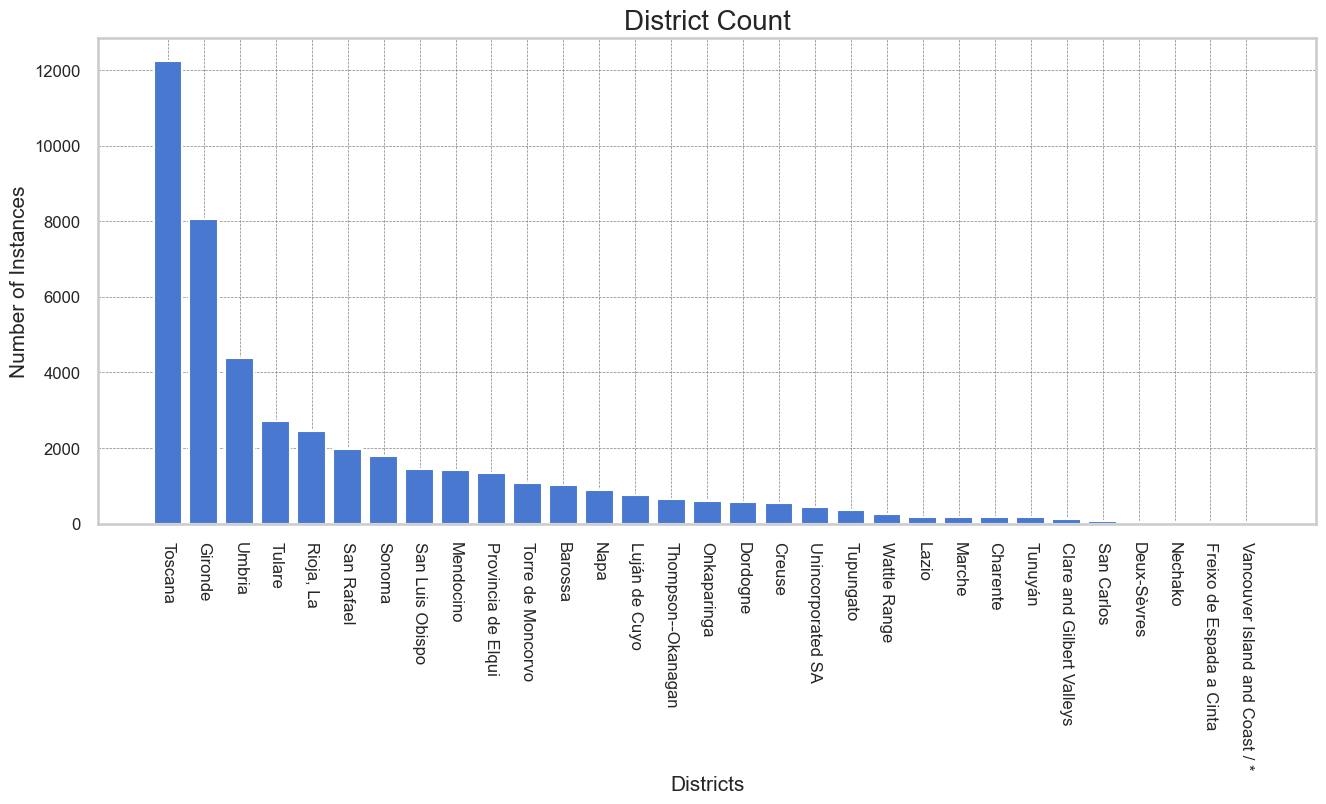

In [10]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Define the data
categories =  train['District'].value_counts()

#Customizing Bar Plot
plt.bar(categories.index, categories.values)

#Adding labels and title
plt.xlabel('Districts')
plt.ylabel('Number of Instances')
plt.title('District Count')

#Rotate data
plt.xticks(rotation=270)

#Show the plot
plt.show()

## Data Cleaning Engineering
Following the input of the data, extensive measurements must be taken to clean and format the data. 

The cleaning process involves: 
- Drops duplicate rows
- NaN values are filled in the training dataset code section



In [11]:
def Cleaning_Data(DataFrame_Clean):
    """
    Input: initial DataFrame data

    Cleans a DataFrame_ through four processes:
        1. Drops duplicate rows
        2. fills NaN values 

    Output: Cleaned DataFrame
    """

    #Drops any rows with the name producer/year
    DataFrame_Clean['Producer_WineType_Year'] = DataFrame_Clean['Producer'] + DataFrame_Clean['WineType'] + DataFrame_Clean['Year'].astype(str)
    DataFrame_Clean = DataFrame_Clean.drop_duplicates(subset = 'Producer_WineType_Year')

    #Drops 'type' columns
    DataFrame_Clean = DataFrame_Clean.drop(columns = ['Type']).dropna()
    

    return DataFrame_Clean

# Feature Engineering

This chunk of code sets out all the features that were considered for the design of a model


In [12]:
def Features(DataFrame):
    """
    Adds all features to the dataframe
    """
    months = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February']
    seasons = {'Spring' : ['March', 'April', 'May'], 'Summer' : ['June', 'July', 'August'], 'Fall' : ['September', 'October', 'November'], 'Winter' : ['December', 'January', 'February']}

    for month in months: 

        #Add feature for tempxhumidity interaction 
        DataFrame[f'{month}_Temp_Humidity'] = DataFrame[f'{month} Avg Temp (°C)'] * DataFrame[f'{month} Avg Relative Humidity']

    for season in seasons:
    
        #Add feature for seasonal average temperature
        DataFrame[f'{season}_Avg_Temp'] = DataFrame[[f'{month} Avg Temp (°C)' for month in seasons[season]]].mean(axis = 1)

        #Add feature for humidity average temperature
        DataFrame[f'{season}_Avg_Humid'] = DataFrame[[f'{month} Avg Relative Humidity' for month in seasons[season]]].mean(axis = 1)

        #Add feature for seasonal average precip
        DataFrame[f'{season}_Avg_Precip'] = DataFrame[[f'{month} Cumulative Precip (mm)' for month in seasons[season]]].mean(axis = 1)
        
        #Add feature for seasonal average cloud cover
        DataFrame[f'{season}_Avg_Cloud_Cover'] = DataFrame[[f'{month} Avg Cloud Cover (%)' for month in seasons[season]]].mean(axis = 1)

        #Add feature for seasonal daylight hours
        DataFrame[f'{season}_Avg_Daylight_Hrs'] = DataFrame[[f'{month} Avg Daylight Hours' for month in seasons[season]]].mean(axis = 1)
    
        #Add feature for seasonal temp humidity
        DataFrame[f'{season}_Temp_Humidity'] = DataFrame[[f'{month}_Temp_Humidity' for month in seasons[season]]].mean(axis = 1)

        #Add feature for days below 0 per month
        DataFrame[f'{season}_Days_Below_0'] = DataFrame[[f'{month} Days Below 0 (°C)' for month in seasons[season]]].sum(axis = 1)
    
        #Add feature for days above 32 per month
        DataFrame[f'{season}_Days_Above_32'] = DataFrame[[f'{month} Days Above 32 (°C)' for month in seasons[season]]].sum(axis = 1)
    
    #Add feature for annual precip
    DataFrame['Yearly_Precip'] = DataFrame[[f'{month} Cumulative Precip (mm)' for month in months]].sum(axis = 1)

    return DataFrame

## Selecting Features 

The feature selection function takes in all the added features, removing many of the ones that were determined to not help the data well. 
- Removed features were done based on the utility graph later on

In [13]:
def Feature_Selection(data):
    """
    Input: Raw data, with every feature from the cleaned train data set
        Commenting them in and out, certain features are chosen for the final model 
    Output: Final dataset, with certain features chosen 
    """
    feature_selected = [
                        'Year',
                        'Price',

                        'Winter_Avg_Temp', 
                        'Spring_Avg_Temp',
                        # 'Summer_Avg_Temp',
                        # 'June Avg Temp (°C)',
                        # 'July Avg Temp (°C)',
                        # 'August Avg Temp (°C)',                                   
                        # 'Fall_Avg_Temp',

                        # 'Winter_Avg_Humid',
                        # 'Spring_Avg_Humid',
                        # 'Summer_Avg_Humid',
                        # 'Fall_Avg_Humid',

                        # 'Winter_Avg_Precip', 
                        # 'Spring_Avg_Precip',
                        'Summer_Avg_Precip',
                        # 'Fall_Avg_Precip',

                        # 'Winter_Avg_Cloud_Cover',
                        # 'January Avg Cloud Cover (%)',
                        # 'February Avg Cloud Cover (%)',
                        # 'Spring_Avg_Cloud_Cover',
                        # 'March Avg Cloud Cover (%)',
                        # 'April Avg Cloud Cover (%)',
                        # 'May Avg Cloud Cover (%)',
                        # 'Summer_Avg_Cloud_Cover',
                        # 'Fall_Avg_Cloud_Cover',

                        # 'Winter_Avg_Daylight_Hrs',
                        # 'Spring_Avg_Daylight_Hrs',
                        # 'Summer_Avg_Daylight_Hrs',
                        # 'Fall_Avg_Daylight_Hrs',

                        # 'Winter_Temp_Humidity',
                        'Spring_Temp_Humidity',
                        # 'Summer_Temp_Humidity',
                        # 'Fall_Temp_Humidity',

                        # 'Winter_Days_Below_0',
                        # 'Spring_Days_Below_0',
                        # 'Summer_Days_Below_0',
                        # 'Fall_Days_Below_0',
                        
                        # 'Winter_Days_Above_32',
                        # 'Spring_Days_Above_32',
                        # 'Summer_Days_Above_32',
                        # 'Fall_Days_Above_32',

                        'Acidity',
                        'Intensity',
                        'Sweetness',
                        'Tannin',
                                                
                        ]

    selected_data = data[feature_selected]
    selected_data = selected_data.astype(np.float32)

    return selected_data

---

## Global Trends

Thinking high level, how data was created, no normalization occured to ensure that winter months in one country were similar to winter months in another
- as such, preliminary mondels show an accuracy of about xxx with all the data, and xxx when data is separated by more similar countries

In [14]:
train['District'].unique()

array(['Sonoma', 'Tulare', 'San Luis Obispo', 'Napa', 'Mendocino',
       'Nechako', 'Thompson--Okanagan', 'San Rafael', 'Luján de Cuyo',
       'Tunuyán', 'San Carlos', 'Tupungato', 'Barossa', 'Onkaparinga',
       'Unincorporated SA', 'Wattle Range', 'Toscana', 'Umbria', 'Marche',
       'Lazio', 'Gironde', 'Provincia de Elqui', 'Dordogne', 'Creuse',
       'Deux-Sèvres', 'Charente', 'Rioja, La',
       'Clare and Gilbert Valleys', 'Vancouver Island and Coast / *',
       'Torre de Moncorvo', 'Freixo de Espada a Cinta'], dtype=object)

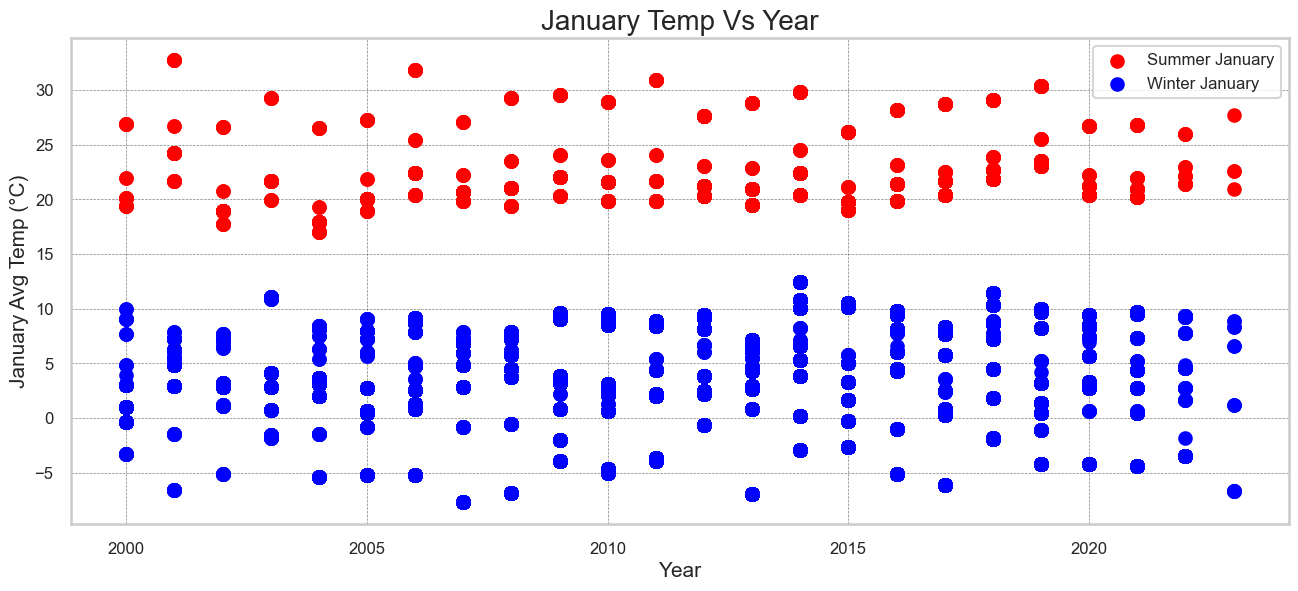

In [15]:
#Set out figure size
plt.figure(figsize=(14, 6))

# Sets out scatterplot
train_1 = train[(train['District'] == 'Clare and Gilbert Valleys') |
                (train['District'] == 'Unincorporated SA') | 
                (train['District'] == 'Onkaparinga') | 
                (train['District'] == 'Barossa') |
                (train['District'] == 'Wattle Range')    
                ] 

train_2 = train[(train['District'] != 'Clare and Gilbert Valleys') &
                (train['District'] != 'Unincorporated SA') & 
                (train['District'] != 'Onkaparinga') &
                (train['District'] != 'Barossa') &
                (train['District'] != 'Wattle Range') 
                ] 

plt.scatter(x = train_1['Year'], y = train_1['January Avg Temp (°C)'], label = 'Summer January', color = 'red')
plt.scatter(x = train_2['Year'], y = train_2['January Avg Temp (°C)'], label = 'Winter January', color = 'blue')

#Adding labels and title
plt.xlabel('Year', fontsize = 15)
plt.ylabel('January Avg Temp (°C)', fontsize = 15)
plt.title('January Temp Vs Year', fontsize = 20)
plt.legend()

#Show the plot
plt.show()

Looking at the above plot, two distinct zones of temperatures can be seen. This corresponds to the predicted results for the different global january temperatures. Looking at the plot, 14°C will be used as the delinator to separate the two chunks of data

## Different Data 
Since there is a difference between the data, to see if the influence of changes in weather across the globe we can split up the data into three models. The first model will be all the data, second model will be the southern hemisphere data and the third model will be the northern hemisphere data.

In [16]:
train_chunk_1 = train_1
train_chunk_2 = train_2

---
# Model 1 - All Data

## Selecting and Splitting Data


In [17]:
train = Cleaning_Data(train)
train = Features(train)

X_data = Feature_Selection(train)
y_data = train['Ratings_Average']

model = RandomForestRegressor() 

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, train_size = 0.8, random_state = 42)


### Training and Evaluating a Model

Simple model initially to iterate quickly to check r2 scores

Following this, hyperparameters were determined for the final submissions

In [18]:
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(r2_score(y_val, y_pred))

0.8719330934878002


### Evaluating features

Iterated through this evaluation code to determine best combination of the many features and how many should be included


Top 15 Important Features:
                Feature  Importance
1                 Price    0.778982
0                  Year    0.043107
2       Winter_Avg_Temp    0.029788
4     Summer_Avg_Precip    0.029235
6               Acidity    0.027763
3       Spring_Avg_Temp    0.024272
5  Spring_Temp_Humidity    0.023872
7             Intensity    0.019182
9                Tannin    0.017161
8             Sweetness    0.006639


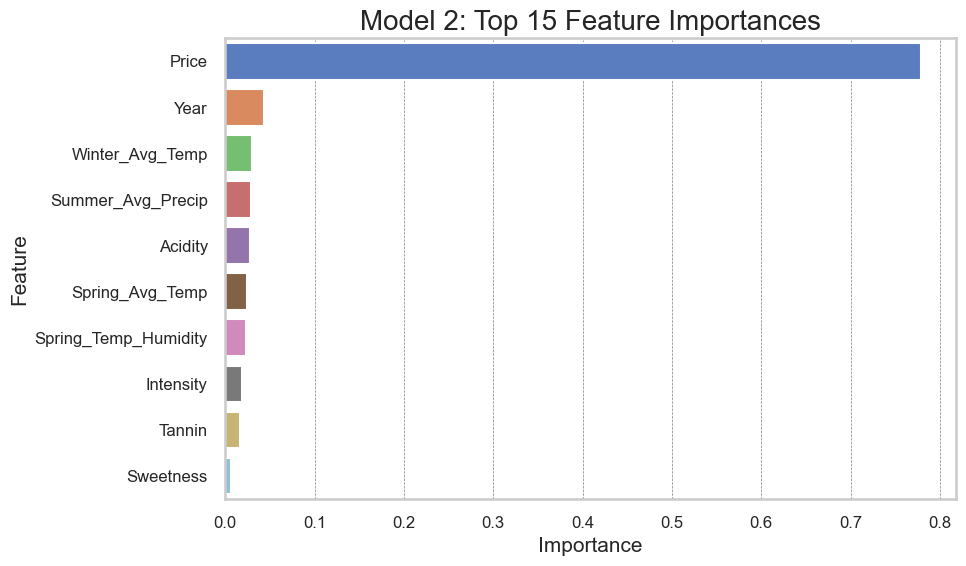

In [19]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 15 Important Features:")
print(feature_importance_df.head(15))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Model 2: Top 15 Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()

---
# Model 2 - Broken Up Data Chunk 1 -Australian Winter (Summer)

### Selecting Features 

Features need to be changed for each of the new models

This model shows the influence of the conflicting data points for the weather. As there is a small jump in accuracy when we separate the nothern and southern hemispheres

In [20]:
def Feature_Selection_Chunk_1(data):
    """
    Input: Raw data, with every feature from the cleaned train data set
        Commenting them in and out, certain features are chosen for the final model 
    Output: Final dataset, with certain features chosen 
    """
    feature_selected = [
                        'Year',
                        'Price',

                        # 'Winter_Avg_Temp', 
                        # 'Spring_Avg_Temp',
                        'Summer_Avg_Temp',
                        # 'June Avg Temp (°C)',
                        # 'July Avg Temp (°C)',
                        # 'August Avg Temp (°C)',                                   
                        'Fall_Avg_Temp',

                        # 'Winter_Avg_Humid',
                        # 'Spring_Avg_Humid',
                        # 'Summer_Avg_Humid',
                        # 'Fall_Avg_Humid',

                        'Winter_Avg_Precip', 
                        # 'Spring_Avg_Precip',
                        # 'Summer_Avg_Precip',
                        # 'Fall_Avg_Precip',

                        # 'Winter_Avg_Cloud_Cover',
                        # 'January Avg Cloud Cover (%)',
                        # 'February Avg Cloud Cover (%)',
                        # 'Spring_Avg_Cloud_Cover',
                        # 'March Avg Cloud Cover (%)',
                        # 'April Avg Cloud Cover (%)',
                        # 'May Avg Cloud Cover (%)',
                        # 'Summer_Avg_Cloud_Cover',
                        # 'Fall_Avg_Cloud_Cover',

                        'Winter_Avg_Daylight_Hrs',
                        'Spring_Avg_Daylight_Hrs',
                        # 'Summer_Avg_Daylight_Hrs',
                        # 'Fall_Avg_Daylight_Hrs',

                        # 'Winter_Temp_Humidity',
                        # 'Spring_Temp_Humidity',
                        'Summer_Temp_Humidity',
                        # 'Fall_Temp_Humidity',

                        # 'Winter_Days_Below_0',
                        # 'Spring_Days_Below_0',
                        # 'Summer_Days_Below_0',
                        # 'Fall_Days_Below_0',
                        
                        # 'Winter_Days_Above_32',
                        # 'Spring_Days_Above_32',
                        # 'Summer_Days_Above_32',
                        # 'Fall_Days_Above_32',

                        'Acidity',
                        'Intensity',
                        'Sweetness',
                        'Tannin',
                                                
                        ]

    selected_data = data[feature_selected]
    selected_data = selected_data.astype(np.float32)

    return selected_data


### Selecting and Splitting Data Chunk 1

For this model, data will be broken up based on similar weathers for regions

In [21]:
train_chunk_1 = Cleaning_Data(train_chunk_1)
train_chunk_1 = Features(train_chunk_1)

X_data_1 = Feature_Selection_Chunk_1(train_chunk_1)
y_data_1 = train_chunk_1['Ratings_Average']

model = RandomForestRegressor() 

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_data_1, y_data_1, train_size = 0.8, random_state = 42)

model.fit(X_train_1, y_train_1)

y_pred_1 = model.predict(X_val_1)
print(r2_score(y_val_1, y_pred_1))

0.9146658530652729


### Evaluating features Chunk 1

Iterated through this evaluation code to determine best combination of the many features and how many should be included


Top 15 Important Features:
                    Feature  Importance
1                     Price    0.855655
0                      Year    0.029473
9                 Intensity    0.020572
5   Winter_Avg_Daylight_Hrs    0.015159
4         Winter_Avg_Precip    0.014004
6   Spring_Avg_Daylight_Hrs    0.013639
3             Fall_Avg_Temp    0.012452
2           Summer_Avg_Temp    0.012159
7      Summer_Temp_Humidity    0.010849
8                   Acidity    0.007882
11                   Tannin    0.006086
10                Sweetness    0.002071


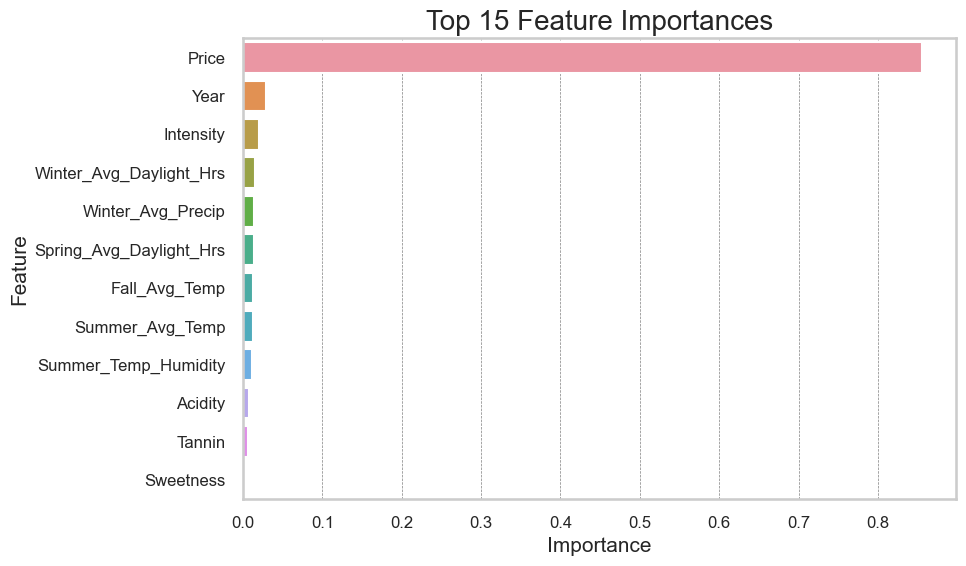

In [22]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data_1.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 15 Important Features:")
print(feature_importance_df.head(15))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

---
# Model 3 - Broken Up Data Chunk 2 - Normal Winter

### Selecting Features 

Features need to be changed for each of the new models

In [23]:
def Feature_Selection_Chunk_2(data):
    """
    Input: Raw data, with every feature from the cleaned train data set
        Commenting them in and out, certain features are chosen for the final model 
    Output: Final dataset, with certain features chosen 
    """
    feature_selected = [
                        'Year',
                        'Price',

                        'Winter_Avg_Temp', 
                        # 'Spring_Avg_Temp',
                        'Summer_Avg_Temp',
                        # 'June Avg Temp (°C)',
                        # 'July Avg Temp (°C)',
                        # 'August Avg Temp (°C)',                                   
                        # 'Fall_Avg_Temp',

                        # 'Winter_Avg_Humid',
                        # 'Spring_Avg_Humid',
                        # 'Summer_Avg_Humid',
                        # 'Fall_Avg_Humid',

                        # 'Winter_Avg_Precip', 
                        # 'Spring_Avg_Precip',
                        # 'Summer_Avg_Precip',
                        # 'Fall_Avg_Precip',

                        # 'Winter_Avg_Cloud_Cover',
                        # 'January Avg Cloud Cover (%)',
                        # 'February Avg Cloud Cover (%)',
                        # 'Spring_Avg_Cloud_Cover',
                        # 'March Avg Cloud Cover (%)',
                        # 'April Avg Cloud Cover (%)',
                        # 'May Avg Cloud Cover (%)',
                        # 'Summer_Avg_Cloud_Cover',
                        # 'Fall_Avg_Cloud_Cover',

                        # 'Winter_Avg_Daylight_Hrs',
                        # 'Spring_Avg_Daylight_Hrs',
                        # 'Summer_Avg_Daylight_Hrs',
                        # 'Fall_Avg_Daylight_Hrs',

                        'Winter_Temp_Humidity',
                        # 'Spring_Temp_Humidity',
                        'Summer_Temp_Humidity',
                        # 'Fall_Temp_Humidity',

                        # 'Winter_Days_Below_0',
                        # 'Spring_Days_Below_0',
                        # 'Summer_Days_Below_0',
                        # 'Fall_Days_Below_0',
                        
                        # 'Winter_Days_Above_32',
                        # 'Spring_Days_Above_32',
                        # 'Summer_Days_Above_32',
                        # 'Fall_Days_Above_32',

                        'Acidity',
                        'Intensity',
                        'Sweetness',
                        'Tannin',
                                                
                        ]

    selected_data = data[feature_selected]
    selected_data = selected_data.astype(np.float32)

    return selected_data


### Selecting and Splitting Data

For this model, data will be broken up based on similar weathers for regions

In [24]:
train_chunk_2 = Cleaning_Data(train_chunk_2)
train_chunk_2 = Features(train_chunk_2)

X_data_2 = Feature_Selection_Chunk_2(train_chunk_2)
y_data_2 = train_chunk_2['Ratings_Average']

model = RandomForestRegressor() 

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_data_2, y_data_2, train_size = 0.8, random_state = 42)

model.fit(X_train_2, y_train_2)

y_pred_2 = model.predict(X_val_2)
print(r2_score(y_val_2, y_pred_2))

0.8765205422319297



### Selecting and Splitting Data

For this model, data will be broken up based on similar weathers for regions


Top 15 Important Features:
                Feature  Importance
1                 Price    0.772578
0                  Year    0.047956
6               Acidity    0.030525
3       Summer_Avg_Temp    0.030511
5  Summer_Temp_Humidity    0.030400
2       Winter_Avg_Temp    0.022608
4  Winter_Temp_Humidity    0.021811
7             Intensity    0.019747
9                Tannin    0.017262
8             Sweetness    0.006602


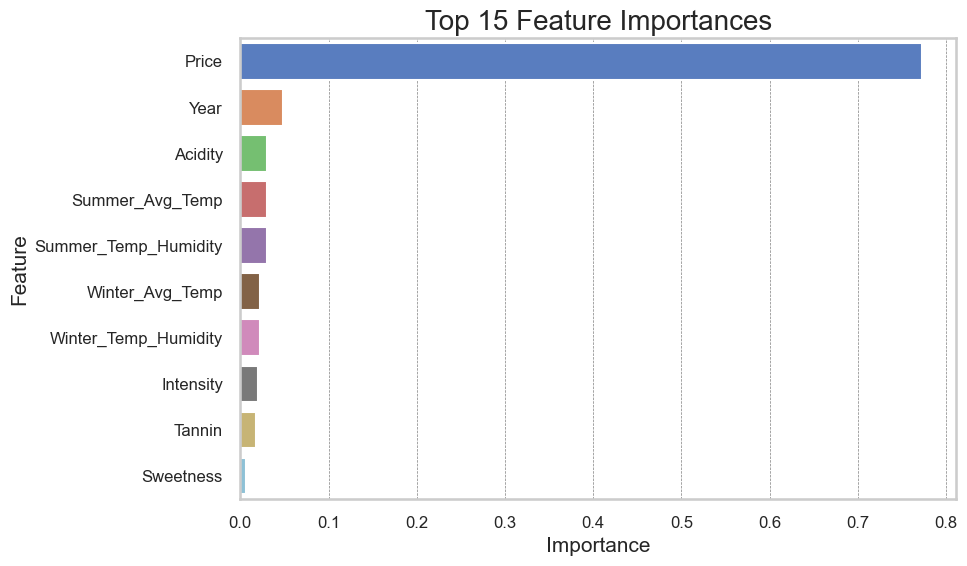

In [25]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data_2.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 15 Important Features:")
print(feature_importance_df.head(15))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

---
# Visualization 

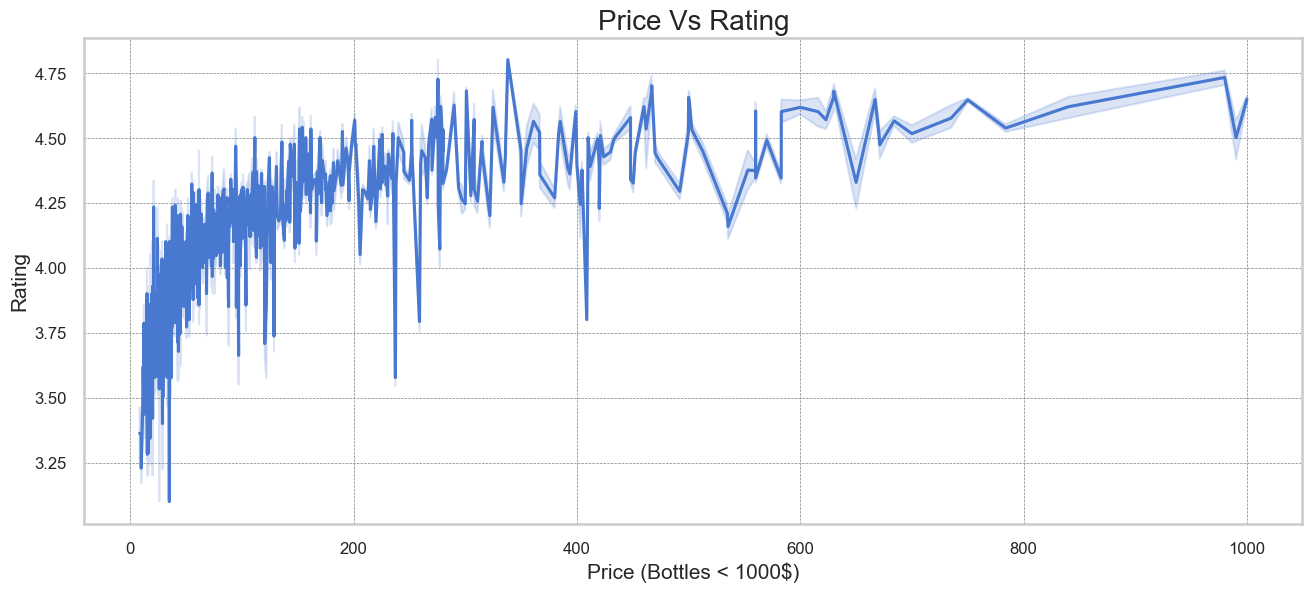

In [26]:
#Set out figure size
plt.figure(figsize=(14, 6))

#Set out lineplot and data
sns.lineplot(data = train[train['Price'] < 1000], x = 'Price', y = 'Ratings_Average')

#Adding labels and title
plt.xlabel('Price (Bottles < 1000$)')
plt.ylabel('Rating')
plt.title('Price Vs Rating', fontsize = 20)

#Show the plot
plt.show()

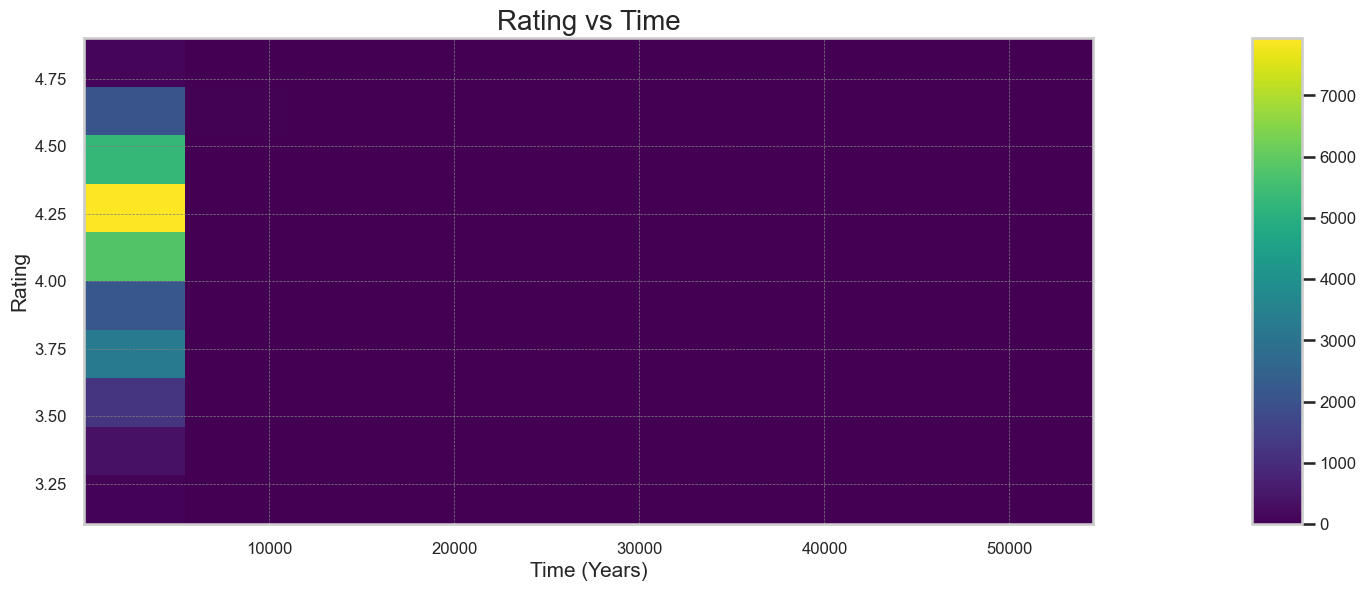

In [27]:
#Define figure size
fig = plt.figure(figsize = (14, 6)) 
gs = fig.add_gridspec(1, 2, width_ratios = [20, 1], wspace=0.3)

#Create heatmap
heatmap, xedges, yedges = np.histogram2d(train['Price'], train['Ratings_Average'], bins=(10, 10))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#Add Heatmap
ax0 = fig.add_subplot(gs[0, 0])
img = ax0.imshow(heatmap.T, extent = extent, origin = 'lower', cmap = 'viridis', aspect = 'auto')
ax0.set_title('Rating vs Time', fontsize = 20)
ax0.set_xlabel('Time (Years)')
ax0.set_ylabel('Rating')

#Add colour bar
ax1 = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(img, cax=ax1)

#Plot
plt.show()